In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

# Load the datasets
info_path = "dataset/TCGA_InfoWithGrade.csv"
mutations_path = "dataset/TCGA_GBM_LGG_Mutations_all.csv"
df_info = pd.read_csv(info_path)
df_mutations = pd.read_csv(mutations_path)

# Preprocessing: Normalize Gender and Grade encoding

# Mapping Gender
gender_mapping = {0: 0, 1: 1, 2: 1}
df_info["Gender"] = df_info["Gender"].map(gender_mapping)
df_mutations["Gender"] = df_mutations["Gender"].map(gender_mapping)

# Handle 'Grade' conversion
grade_mapping = {"LGG": 1, "HGG": 2}
df_mutations["Grade"] = df_mutations["Grade"].replace(grade_mapping)
df_mutations["Grade"] = pd.to_numeric(df_mutations["Grade"], errors="coerce").fillna(0).astype(int)

# Impute missing values (Example for 'Age_at_diagnosis')
imputer = SimpleImputer(strategy='median')
df_info['Age_at_diagnosis'] = imputer.fit_transform(df_info[['Age_at_diagnosis']])

# Standardization
scaler = StandardScaler()
df_info["Age_at_diagnosis"] = scaler.fit_transform(df_info[["Age_at_diagnosis"]])

# One-Hot Encoding for categorical columns
df_info = pd.get_dummies(df_info, columns=['Gender', 'Grade'], drop_first=True)

# Outlier detection using IQR
Q1 = df_info['Age_at_diagnosis'].quantile(0.25)
Q3 = df_info['Age_at_diagnosis'].quantile(0.75)
IQR = Q3 - Q1
df_info = df_info[(df_info['Age_at_diagnosis'] >= (Q1 - 1.5 * IQR)) & (df_info['Age_at_diagnosis'] <= (Q3 + 1.5 * IQR))]

df_info.head()

,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,...,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Gender_1,Grade_1
0,0.023233,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,False,False
1,-0.778400,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,False,False
2,-1.004616,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,False,False
3,-1.156913,0,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,True,False
4,-1.237841,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,False,False


In [3]:
df_mutations.describe()

,Grade,Gender
count,862.000000,0.0
mean,0.578886,NaN
std,0.494024,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,1.000000,NaN
75%,1.000000,NaN
max,1.000000,NaN


In [4]:
import pandas as pd
import numpy as np
import re
from sklearn.impute import SimpleImputer

# Load the dataset
df_mutations = pd.read_csv("dataset/TCGA_GBM_LGG_Mutations_all.csv")

# Function to extract numeric age from string (e.g., '51 years 108 days')
def extract_numeric_age(age_str):
    # Extract the first numeric value from the string
    match = re.match(r"(\d+)", str(age_str))
    if match:
        return int(match.group(1))  # Return the first numeric part
    return np.nan  # Return NaN if no numeric value is found

# Apply the function to clean the 'Age_at_diagnosis' column
df_mutations['Age_at_diagnosis'] = df_mutations['Age_at_diagnosis'].apply(extract_numeric_age)

# Impute missing values for numerical columns (e.g., 'Age_at_diagnosis')
numerical_columns = ['Age_at_diagnosis']  # List of numerical columns to impute
numerical_imputer = SimpleImputer(strategy='median')
df_mutations[numerical_columns] = numerical_imputer.fit_transform(df_mutations[numerical_columns])

# Handle categorical missing values (e.g., 'Gender', 'Primary_Diagnosis', 'Race')
categorical_columns = ['Gender', 'Primary_Diagnosis', 'Race']
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_mutations[categorical_columns] = categorical_imputer.fit_transform(df_mutations[categorical_columns])

# One-Hot Encoding for categorical columns ('Gender', 'Primary_Diagnosis', 'Race')
df_mutations = pd.get_dummies(df_mutations, columns=['Gender', 'Primary_Diagnosis', 'Race'], drop_first=True)

# List of mutation columns
mutation_columns = ['IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC', 'MUC16', 'PIK3CA', 
                    'NF1', 'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4', 
                    'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA']

# Mapping 'mutated' to 1 and 'non-mutated' to 0 for the mutation columns
for col in mutation_columns:
    # Check if the value is 'mutated', if so, set it to 1, otherwise 0
    df_mutations[col] = df_mutations[col].apply(lambda x: 1 if str(x).lower() == 'mutated' else 0)

# Outlier Detection using IQR for numerical columns
for column in numerical_columns:
    Q1 = df_mutations[column].quantile(0.25)
    Q3 = df_mutations[column].quantile(0.75)
    IQR = Q3 - Q1
    df_mutations = df_mutations[(df_mutations[column] >= (Q1 - 1.5 * IQR)) & 
                                 (df_mutations[column] <= (Q3 + 1.5 * IQR))]

# Reset index after preprocessing
df_mutations = df_mutations.reset_index(drop=True)

# Check the first few rows after preprocessing
print(df_mutations.head())


  Grade   Project       Case_ID  Age_at_diagnosis  IDH1  TP53  ATRX  PTEN  \
0   LGG  TCGA-LGG  TCGA-DU-8164              51.0     1     0     0     0   
1   LGG  TCGA-LGG  TCGA-QH-A6CY              38.0     1     0     0     0   
2   LGG  TCGA-LGG  TCGA-HW-A5KM              35.0     1     1     1     0   
3   LGG  TCGA-LGG  TCGA-E1-A7YE              32.0     1     1     1     0   
4   LGG  TCGA-LGG  TCGA-S9-A6WG              31.0     1     1     1     0   

   EGFR  CIC  ...  Primary_Diagnosis_Astrocytoma, anaplastic  \
0     0    0  ...                                      False   
1     0    1  ...                                      False   
2     0    0  ...                                      False   
3     0    0  ...                                       True   
4     0    0  ...                                       True   

   Primary_Diagnosis_Glioblastoma  Primary_Diagnosis_Mixed glioma  \
0                           False                           False   
1             

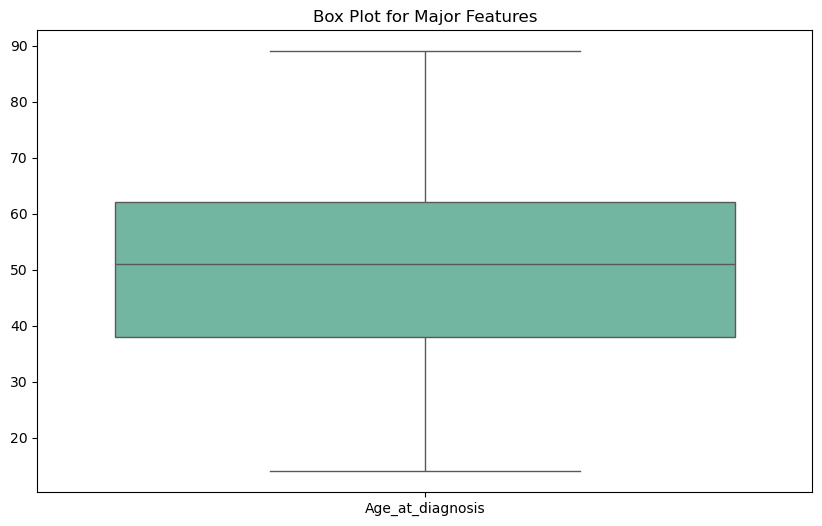

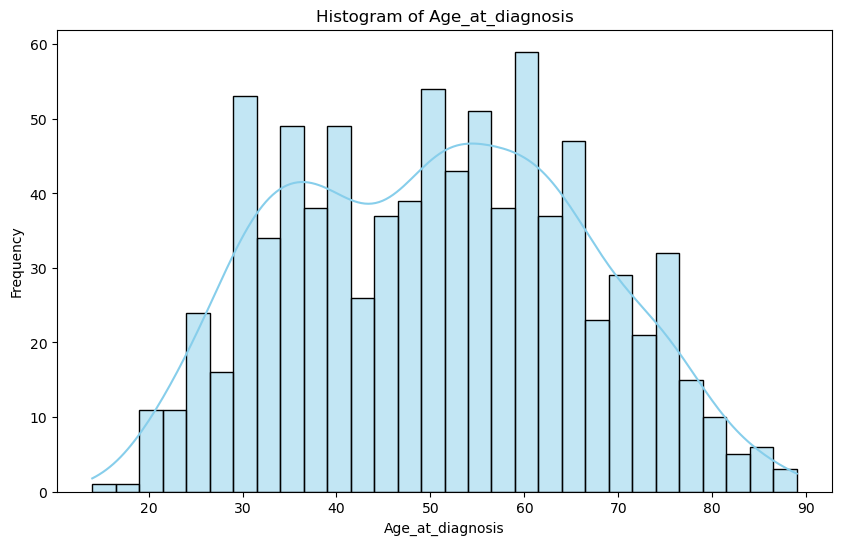

/tmp/ipykernel_6032/350113955.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_mutations, x='Gender', palette='Set1')


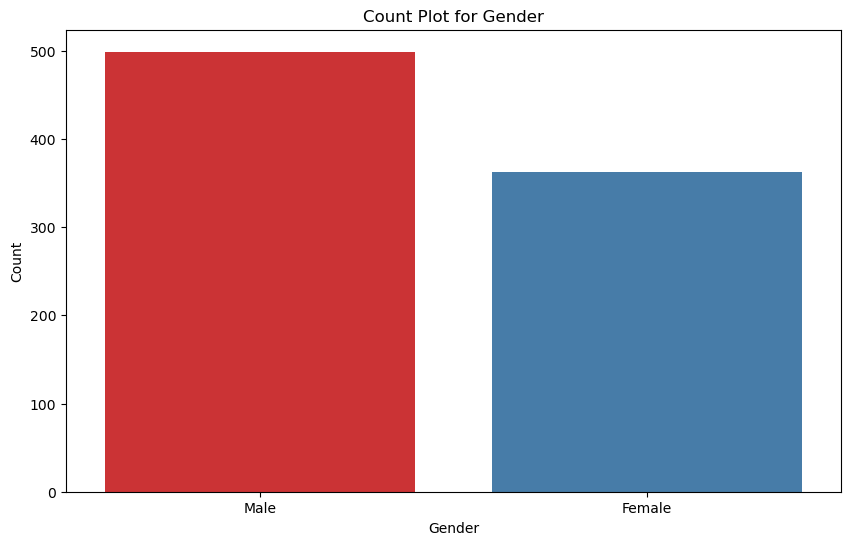

/tmp/ipykernel_6032/350113955.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_race_counts, x='Race', y='Count', palette='Set2')


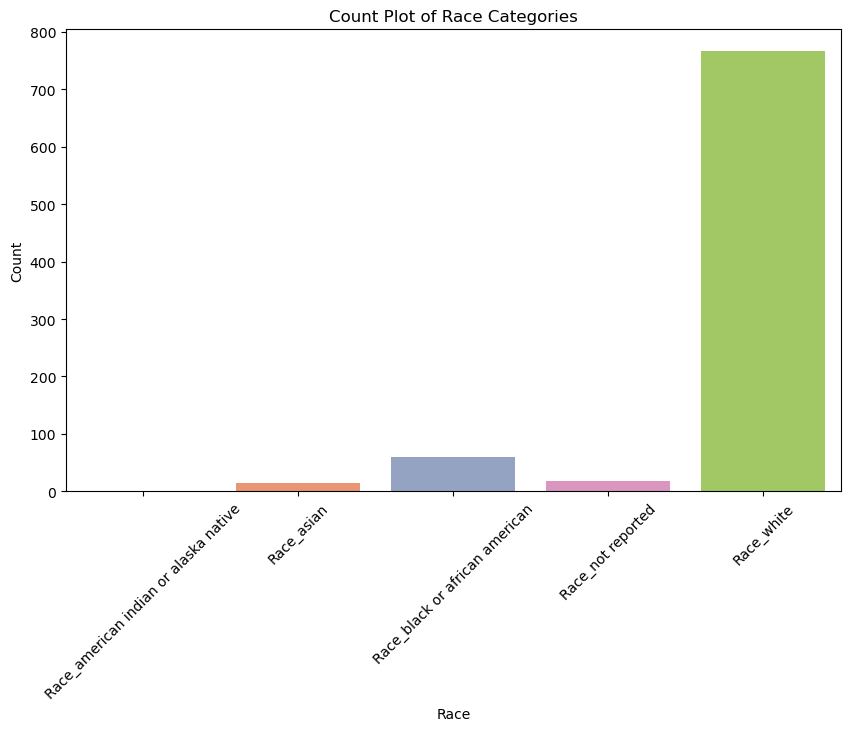

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select major numerical features
major_features = ['Age_at_diagnosis']  # You can add more features as needed
# Create a boxplot for major numerical features
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_mutations[major_features], palette='Set2')
plt.title('Box Plot for Major Features')
plt.show()

# 3. Histogram for 'Age_at_diagnosis'
plt.figure(figsize=(10, 6))
sns.histplot(df_mutations['Age_at_diagnosis'], kde=True, bins=30, color='skyblue')
plt.title('Histogram of Age_at_diagnosis')
plt.xlabel('Age_at_diagnosis')
plt.ylabel('Frequency')
plt.show()

# Combine Gender_Female and Gender_Male into a single column
df_mutations['Gender'] = df_mutations[['Gender_Female', 'Gender_Male']].idxmax(axis=1).str.replace('Gender_', '')

# Now create the count plot using the combined 'Gender' column
plt.figure(figsize=(10, 6))
sns.countplot(data=df_mutations, x='Gender', palette='Set1')
plt.title('Count Plot for Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Assuming these are the encoded columns for 'Race'
race_columns = ['Race_american indian or alaska native', 
                'Race_asian', 
                'Race_black or african american', 
                'Race_not reported', 
                'Race_white']

# Sum the boolean values (True = 1, False = 0) for each race category
df_race_counts = df_mutations[race_columns].sum()

# Convert the series into a DataFrame for easier plotting
df_race_counts = df_race_counts.reset_index()
df_race_counts.columns = ['Race', 'Count']

# Create a count plot (barplot in this case)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_race_counts, x='Race', y='Count', palette='Set2')
plt.title('Count Plot of Race Categories')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

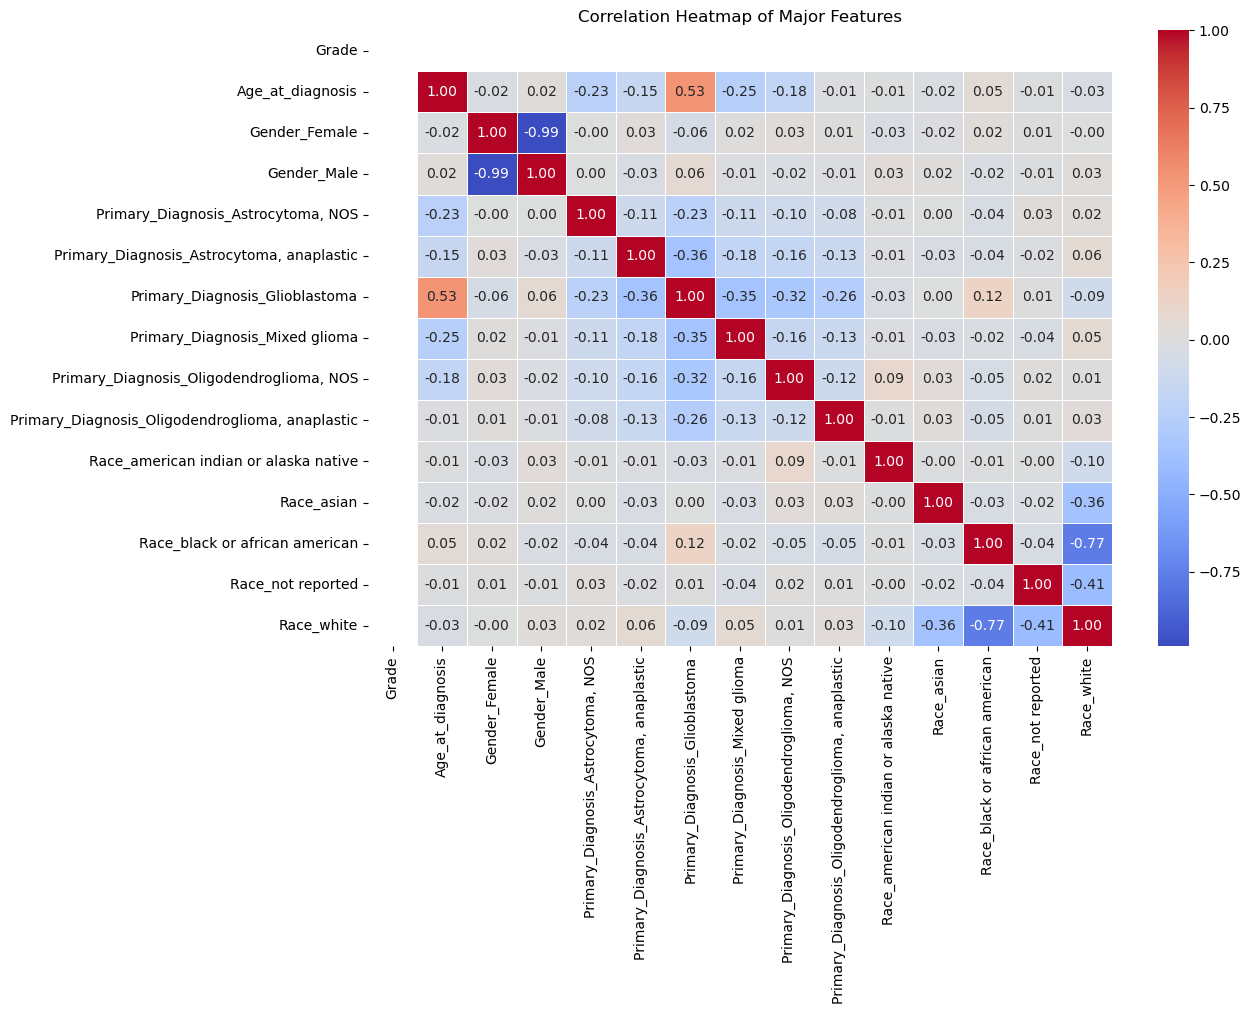

In [6]:
# List of major features to be included in the correlation matrix
major_features = [
    'Grade', 'Age_at_diagnosis','Gender_Female', 'Gender_Male',
    'Primary_Diagnosis_Astrocytoma, NOS', 'Primary_Diagnosis_Astrocytoma, anaplastic', 
    'Primary_Diagnosis_Glioblastoma', 'Primary_Diagnosis_Mixed glioma', 
    'Primary_Diagnosis_Oligodendroglioma, NOS', 'Primary_Diagnosis_Oligodendroglioma, anaplastic', 
    'Race_american indian or alaska native', 'Race_asian', 'Race_black or african american', 
    'Race_not reported', 'Race_white'
]

# Select only the columns corresponding to major features
major_features_df = df_mutations[major_features]

# Ensure the columns selected are numeric (if not, handle conversion as needed)
major_features_df = major_features_df.apply(pd.to_numeric, errors='coerce')

# Compute the correlation matrix for major features
correlation_matrix = major_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Major Features")
plt.show()


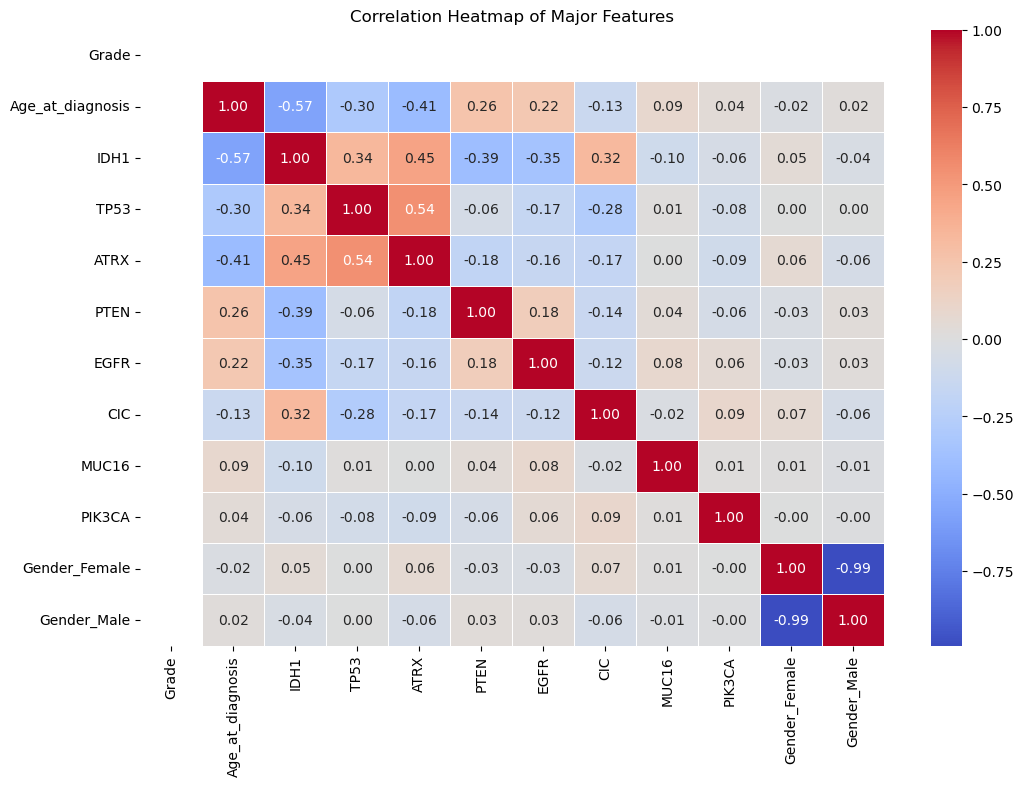

In [7]:
# List of major features to be included in the correlation matrix
major_features = [
    'Grade', 'Age_at_diagnosis', 'IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC',
    'MUC16', 'PIK3CA', 'Gender_Female', 'Gender_Male',
]

# Select only the columns corresponding to major features
major_features_df = df_mutations[major_features]

# Ensure the columns selected are numeric (if not, handle conversion as needed)
major_features_df = major_features_df.apply(pd.to_numeric, errors='coerce')

# Compute the correlation matrix for major features
correlation_matrix = major_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Major Features")
plt.show()

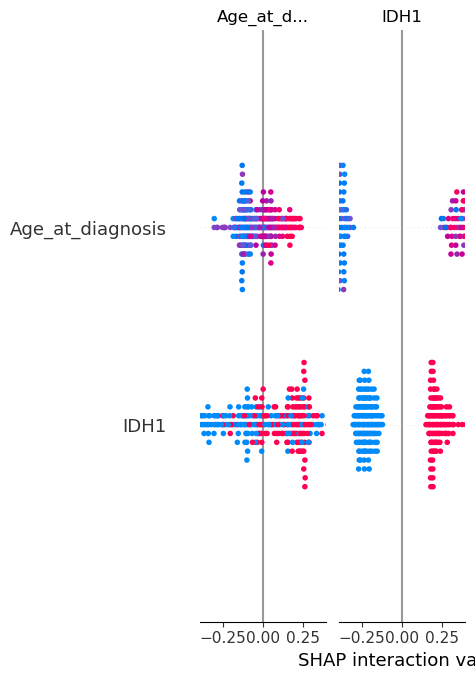

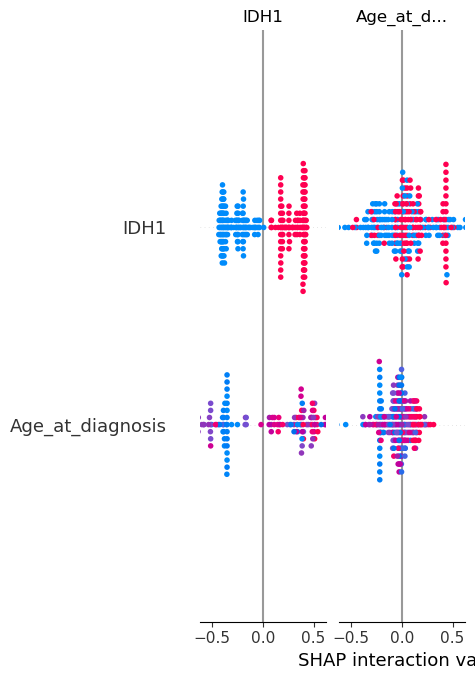

  0%|          | 0/259 [00:00<?, ?it/s]

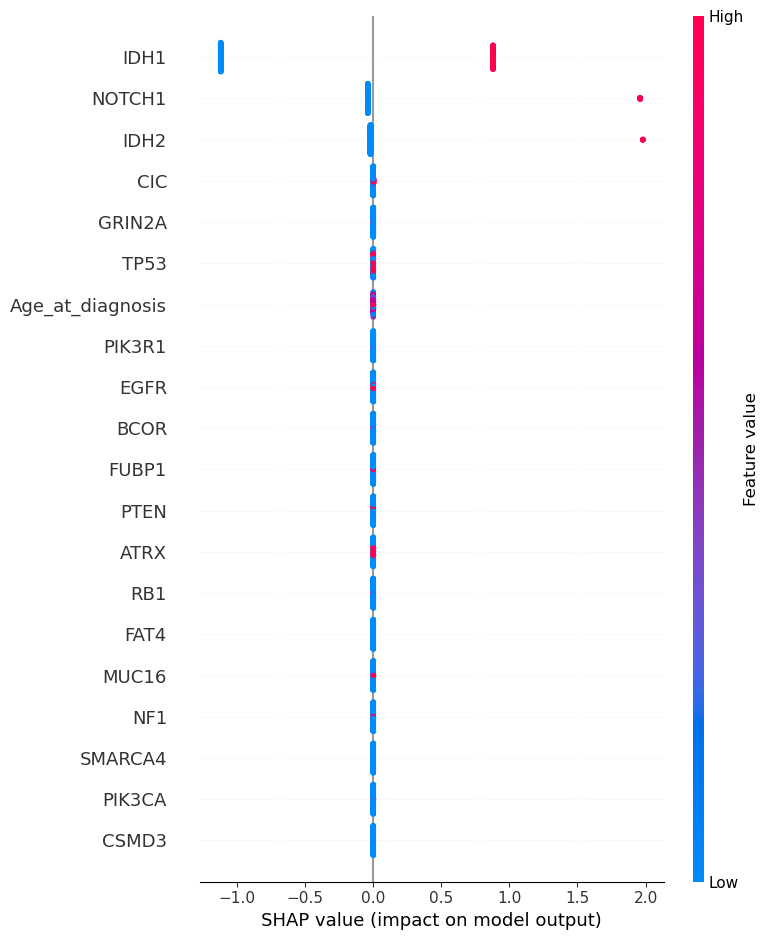

In [11]:
import shap
import numpy as np

# --- SHAP Initialization ---
shap.initjs()  # Initialize SHAP visualization

# --- Sample Background Data ---
K = 100  # Specify the number of samples for summarization
background_rf = shap.sample(X_train_scaled, K)
background_svm = shap.sample(X_train_scaled, K)
background_dt = shap.sample(X_train_scaled, K)

# --- SHAP Explanation for Random Forest ---
explainer_rf = shap.TreeExplainer(rf_model)  # Use TreeExplainer for Random Forest
shap_values_rf = explainer_rf.shap_values(X_test_scaled)

# SHAP summary plot for Random Forest
shap.summary_plot(shap_values_rf, X_test)

# --- SHAP Explanation for Decision Tree ---
explainer_dt = shap.TreeExplainer(dt_model)  # Use TreeExplainer for Decision Tree
shap_values_dt = explainer_dt.shap_values(X_test_scaled)

# SHAP summary plot for Decision Tree
shap.summary_plot(shap_values_dt, X_test)

# --- SHAP Explanation for SVM ---
# Use decision_function for SVM with KernelExplainer and downsampled background
explainer_svm = shap.KernelExplainer(svm_model.decision_function, background_svm)
shap_values_svm = explainer_svm.shap_values(X_test_scaled)

# SHAP summary plot for SVM
shap.summary_plot(shap_values_svm, X_test)


In [9]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

df = df_mutations
# Drop 'Case_ID' and 'Project' columns
X = df.drop(columns=['Case_ID', 'Project'])
y = df['Grade']  # Assuming 'Grade' is the target variable

# Select numerical columns for scaling
X_numeric = X.select_dtypes(include=['float64', 'int64'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.3, random_state=42)

# Scale the numerical features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the models
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(kernel='linear', random_state=42)  # Use linear kernel for feature importance
dt_model = DecisionTreeClassifier(random_state=42)

# Train the models
rf_model.fit(X_train_scaled, y_train)
svm_model.fit(X_train_scaled, y_train)
dt_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
rf_pred = rf_model.predict(X_test_scaled)
svm_pred = svm_model.predict(X_test_scaled)
dt_pred = dt_model.predict(X_test_scaled)

# Evaluate the models
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))

print("\nSVM Classification Report:")
print(classification_report(y_test, svm_pred))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, svm_pred))

print("\nDecision Tree Classification Report:")
print(classification_report(y_test, dt_pred))
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, dt_pred))




Random Forest Classification Report:
              precision    recall  f1-score   support

         GBM       0.75      0.83      0.79       109
         LGG       0.87      0.79      0.83       150

    accuracy                           0.81       259
   macro avg       0.81      0.81      0.81       259
weighted avg       0.82      0.81      0.81       259

Random Forest Confusion Matrix:
[[ 91  18]
 [ 31 119]]

SVM Classification Report:
              precision    recall  f1-score   support

         GBM       0.76      0.94      0.84       109
         LGG       0.94      0.78      0.85       150

    accuracy                           0.85       259
   macro avg       0.85      0.86      0.85       259
weighted avg       0.86      0.85      0.85       259

SVM Confusion Matrix:
[[102   7]
 [ 33 117]]

Decision Tree Classification Report:
              precision    recall  f1-score   support

         GBM       0.71      0.77      0.74       109
         LGG       0.82      0.77 

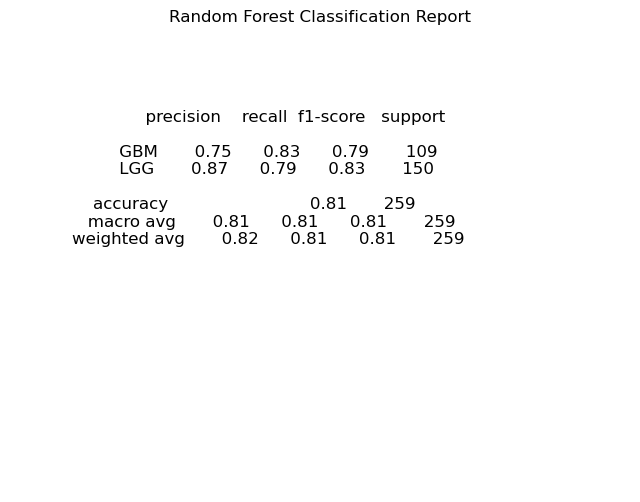

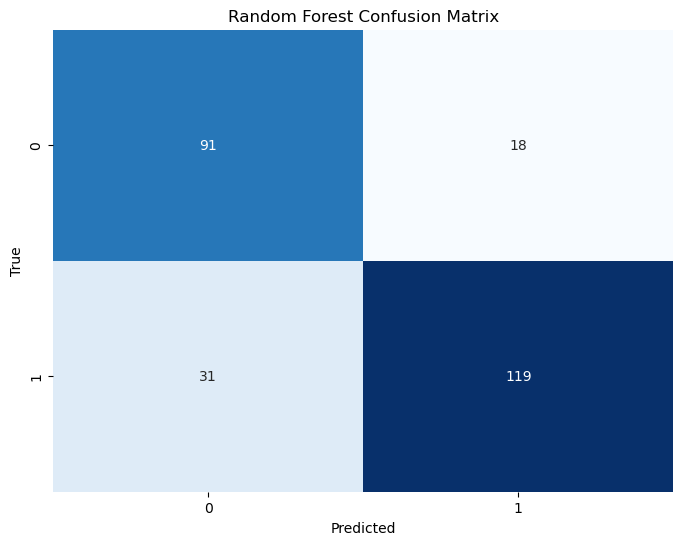

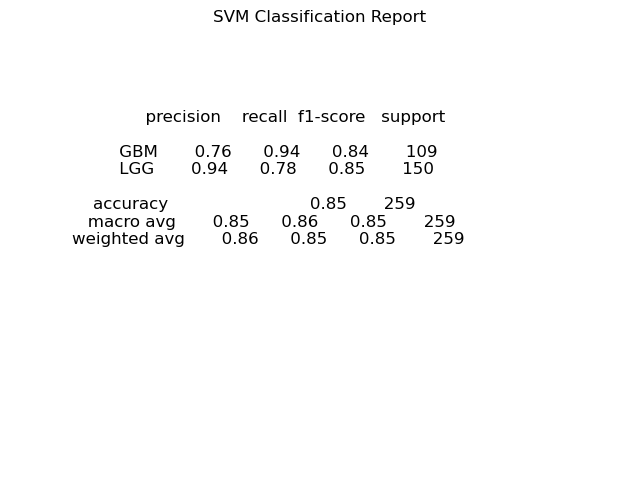

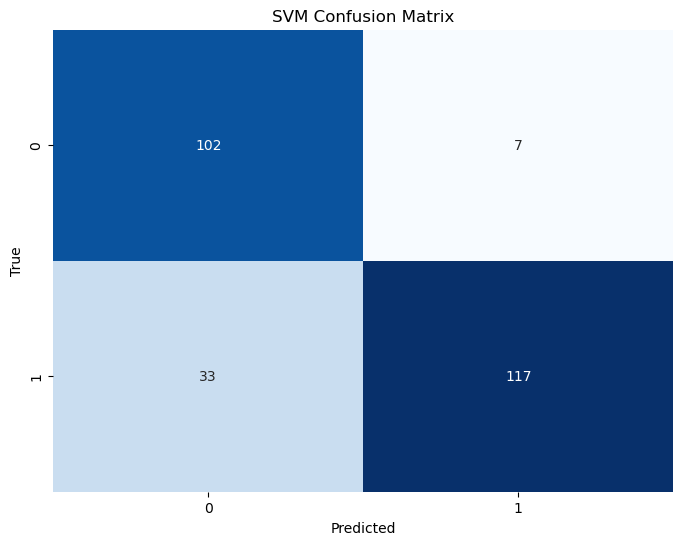

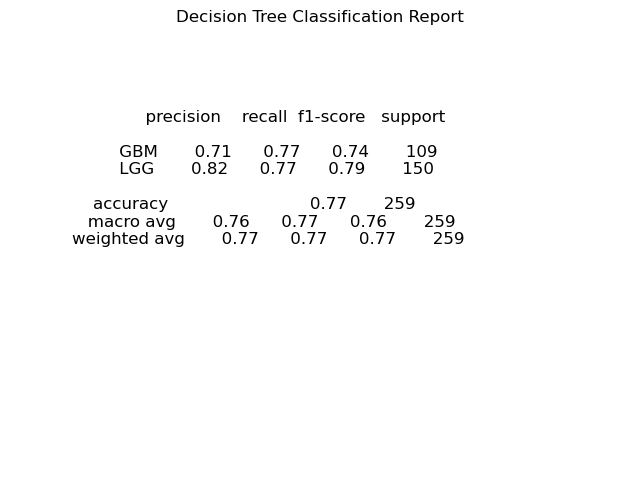

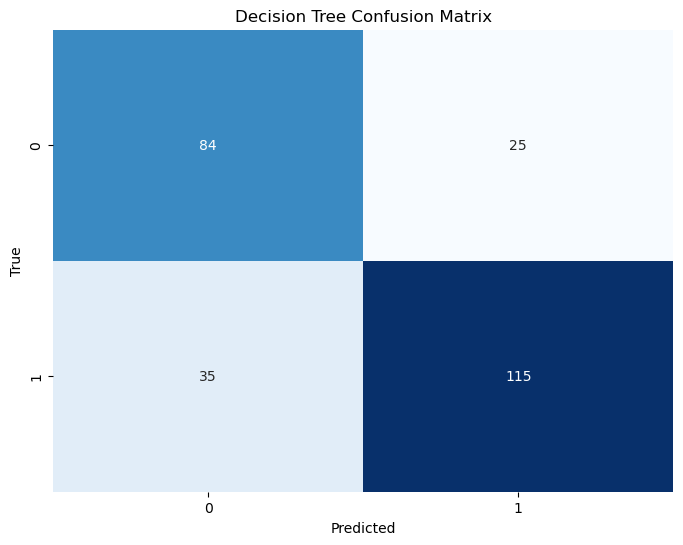

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to plot confusion matrix as an image
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Function to plot classification report as an image
def plot_classification_report(report, model_name):
    plt.figure(figsize=(8, 6))
    plt.axis('off')
    plt.text(0.1, 0.5, report, fontsize=12, ha='left')
    plt.title(f'{model_name} Classification Report')
    plt.show()

# Store models and their predictions
models = {
    "Random Forest": (y_test, rf_pred),
    "SVM": (y_test, svm_pred),
    "Decision Tree": (y_test, dt_pred)
}

# Plot the classification report and confusion matrix separately for each model
for model_name, (y_true, y_pred) in models.items():
    # Get classification report
    report = classification_report(y_true, y_pred)

    # Plot classification report
    plot_classification_report(report, model_name)

    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plot_confusion_matrix(cm, model_name)


In [14]:
import pickle

# Save the trained model to a file using pickle
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)

print("Model training and saving successful!")

Model training and saving successful!


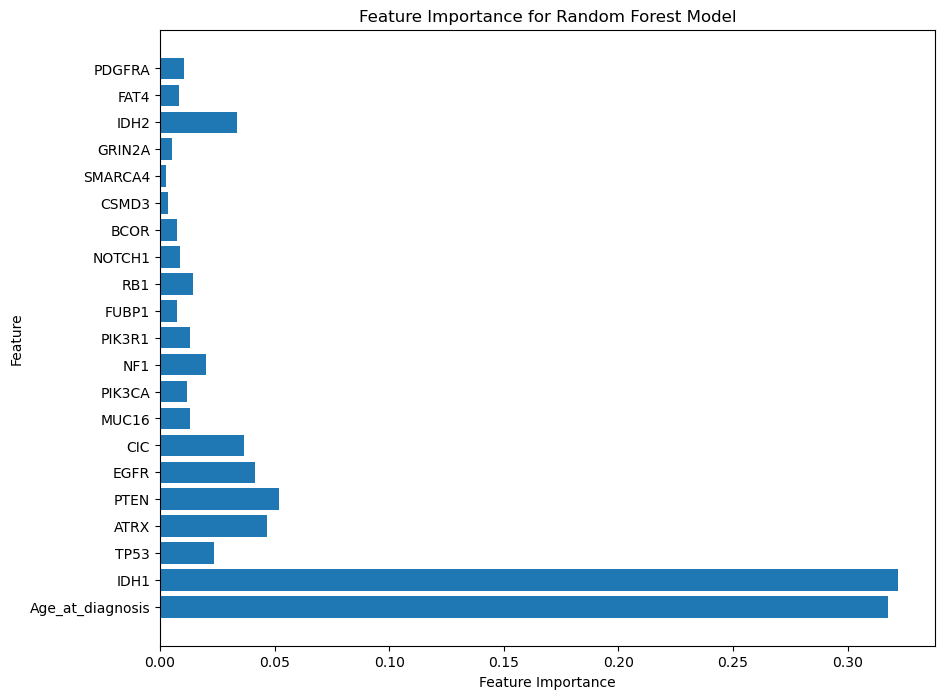

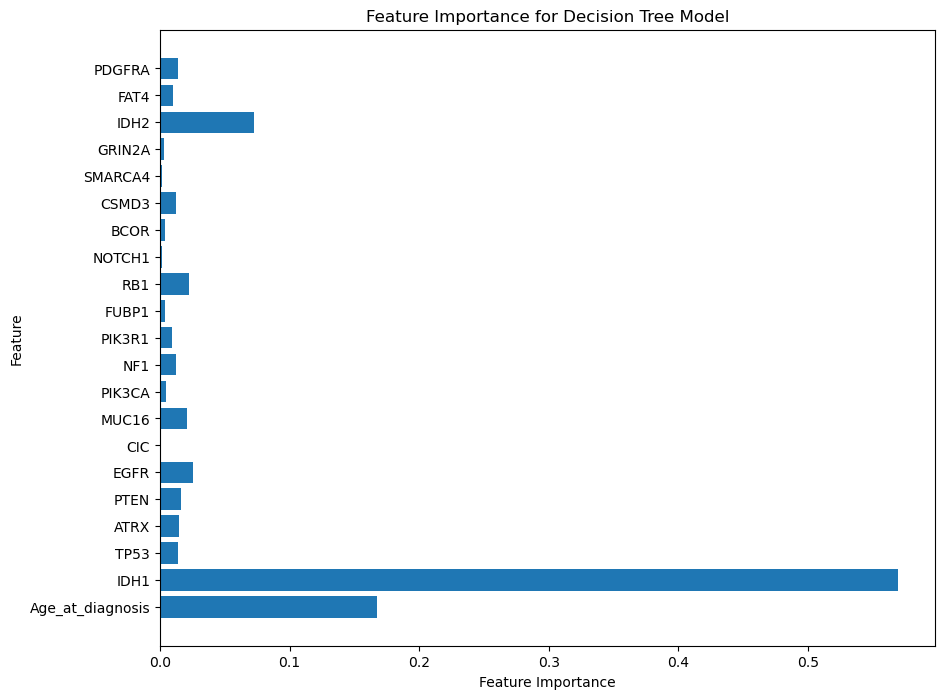

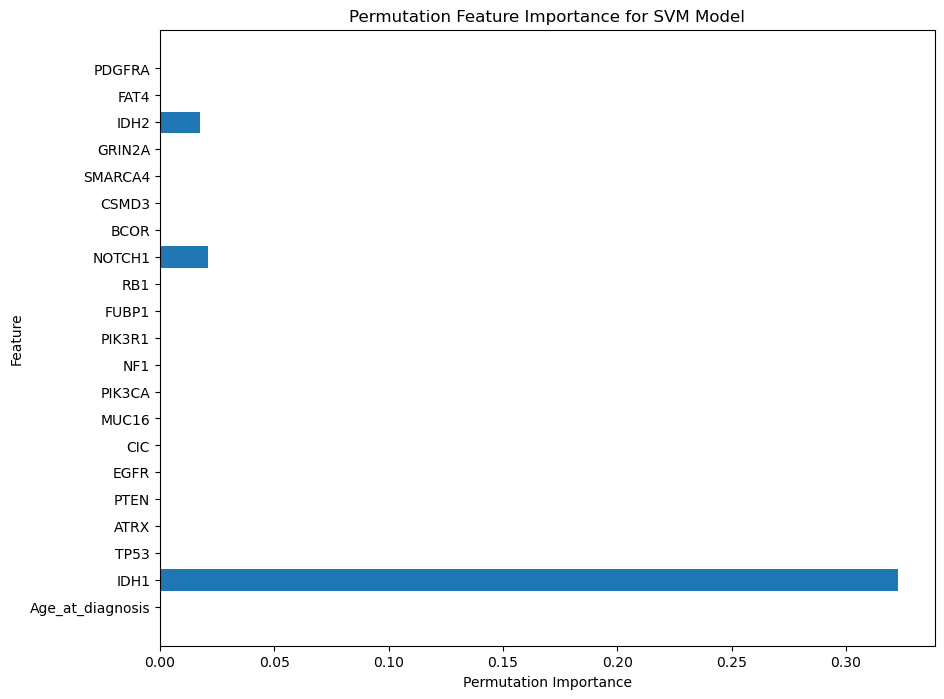

In [10]:
# --- Feature Importance for Random Forest ---
rf_feature_importances = rf_model.feature_importances_
features = X_numeric.columns

# Plot Random Forest Feature Importance
plt.figure(figsize=(10, 8))
plt.barh(features, rf_feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for Random Forest Model")
plt.show()

# --- Feature Importance for Decision Tree ---
dt_feature_importances = dt_model.feature_importances_

# Plot Decision Tree Feature Importance
plt.figure(figsize=(10, 8))
plt.barh(features, dt_feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for Decision Tree Model")
plt.show()

# --- Feature Importance for SVM (using Permutation Importance) ---
perm_importance = permutation_importance(svm_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Plot SVM Feature Importance
plt.figure(figsize=(10, 8))
plt.barh(features, perm_importance.importances_mean)
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance for SVM Model")
plt.show()